# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [12]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [14]:
print_errors = True
build_new_dataset = False
train_new_model = True 
symbol_list = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'
feature_amount = 3000 # deprecated
param_grid = {
        'shuffle': [True], 
        'solver': ['adam'], 
        'learning_rate': ['adaptive'],
        'tol': [0.0001],
        'max_iter': [200],
        'alpha': [0.0001],
        'hidden_layer_sizes': [
            (1000, 1000, 1000), 
            (1000, 1000, 1000, 1000), 
            (2000, 2000),
            (2000, 2000, 2000),
            (3000, 3000),
            (3000, 3000, 3000),
            ],
        'learning_rate_init': [0.001],
        'n_iter_no_change': [6, 9]
    }
verticle_jobs = 1 #'-1' for max

## Data Preparation

In [15]:
if symbol_list == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbol_list == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist() + \
              pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'SYDB.CO', 'UBER', 'GRLA'], dtype=object)

#### Download annual financial data

In [16]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [17]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2025-03-31,NaN,NaN,NaN,Basic Materials,Aluminum,-1.800000e+07,-2.166667e+08,-9.460000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-4.400000e+08,0.000000e+00,-7.200000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243343,Basic Materials,Aluminum,3.420000e+08,-5.000000e+08,-1.000000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,5.300000e+08,-1.500000e+08,-1.294000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574374,Basic Materials,Aluminum,1.035000e+08,-2.166667e+08,-5.782500e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,UBER,2025-03-31,NaN,NaN,NaN,Technology,Software - Application,2.250000e+09,-1.785000e+09,-4.700000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,UBER,2023-12-31,0.219354,0.114032,-0.025024,Technology,Software - Application,3.362000e+09,0.000000e+00,-2.871000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4917,UBER,2022-12-31,0.281844,0.745653,1.489689,Technology,Software - Application,3.900000e+08,0.000000e+00,-2.640000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4918,UBER,2021-12-31,-0.141903,-0.491057,-0.410208,Technology,Software - Application,-7.430000e+08,-4.462500e+08,-8.420000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Removal of low datapoint columns

In [18]:
# columns_to_remove = [col for col in df.columns if df[col].notna().sum() < feature_amount]

# df = df.drop(columns=columns_to_remove)
# print(columns_to_remove)
# df

### Impution and encoding

In [19]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [20]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,0,2025-03-31,NaN,NaN,NaN,0,5,-0.036500,0.080057,0.054585,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
5,2,2025-03-31,NaN,NaN,NaN,8,94,-0.036458,0.000000,0.054774,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
10,3,2025-01-31,NaN,NaN,NaN,7,120,-0.036617,0.095185,0.054759,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
15,4,2025-03-31,NaN,NaN,NaN,8,98,-0.036314,0.092014,0.054026,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
20,5,2025-03-31,NaN,NaN,NaN,6,74,-0.035447,0.075152,0.054568,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,350,2025-03-31,NaN,NaN,NaN,4,82,-0.029817,0.054321,0.054762,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4900,137,2024-12-31,NaN,NaN,NaN,2,67,0.042095,-4.268509,0.050812,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4905,547,2025-03-31,NaN,NaN,NaN,2,67,-0.059289,-0.150089,0.047552,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4910,535,2024-12-31,NaN,NaN,NaN,1,42,-0.035956,0.000000,0.054417,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Net Income Extraordinary,Net Income From Tax Loss Carryforward
1,0,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.036968,0.096835,0.054851,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
2,0,2022-12-31,-0.062309,-0.250328,-0.243343,0,5,-0.036102,0.058116,0.054873,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
3,0,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.035893,0.085219,0.054479,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4,0,2020-12-31,0.398265,0.603471,1.574374,0,5,-0.036366,0.080057,0.054697,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
6,2,2023-12-31,-0.031142,-0.031311,0.220023,8,94,-0.036363,0.000000,0.054816,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4914,535,2020-12-31,-0.048055,-0.134439,-0.731121,1,42,-0.037304,0.000000,0.052411,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4916,967,2023-12-31,0.219354,0.114032,-0.025024,9,117,-0.032755,0.096835,0.053998,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4917,967,2022-12-31,0.281844,0.745653,1.489689,9,117,-0.036048,0.096835,0.054793,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4918,967,2021-12-31,-0.141903,-0.491057,-0.410208,9,117,-0.037304,0.062278,0.054616,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0


### Labeling

In [21]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Net Income Extraordinary,Net Income From Tax Loss Carryforward
3548,288,2,109,-0.036341,0.092220,0.054870,-0.054253,0.052867,-0.072072,-0.071919,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
3926,460,1,66,-0.036591,0.096835,0.054863,-0.054253,0.052864,-0.072137,-0.071963,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
1932,616,8,95,-0.036363,0.096835,0.054805,-0.054175,0.052885,-0.072249,-0.072173,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
2559,808,2,71,-0.035663,0.080335,0.054854,-0.054253,0.052779,-0.071444,-0.071435,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
3071,7,9,114,-0.036330,0.092769,0.054873,0.000000,0.052865,-0.072133,-0.072035,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803,970,2,123,-0.036349,0.096835,0.054357,-0.053760,0.052650,-0.072099,-0.072086,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4132,594,5,13,-0.036298,0.096790,0.054850,-0.054167,0.052881,-0.072164,-0.071659,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4554,830,9,118,-0.036488,0.089213,0.054872,-0.054240,0.052868,-0.072237,-0.072154,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
961,292,4,84,-0.035720,0.096835,0.054873,-0.054079,0.052627,-0.071413,-0.071785,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
3548,-0.186257,-0.138385,0.291260
3926,0.034109,0.165892,-0.068992
1932,0.004568,-0.039551,-0.032487
2559,0.470950,0.588339,1.118384
3071,-0.157449,0.053339,-0.455651
...,...,...,...
4803,0.016000,-0.250667,-0.393600
4132,-0.136188,-0.325447,-0.077757
4554,-0.176596,-0.259574,-0.495745
961,0.185514,-0.098899,-0.369468


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Net Income Extraordinary,Net Income From Tax Loss Carryforward
4352,735,2,110,-0.035809,0.050287,0.054333,-0.053805,5.261703e-02,-0.071087,-0.070753,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
2984,935,2,109,-0.036225,0.082736,0.054842,-0.054224,5.285914e-02,-0.071678,-0.071578,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
3997,485,0,121,-0.036415,0.096835,0.054828,-0.054224,5.288178e-02,-0.072253,-0.072174,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
3252,96,4,128,-0.035909,0.096835,0.054860,-0.054245,5.260325e-02,-0.072046,-0.072084,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
1059,326,6,33,-0.030565,0.075965,0.054582,-0.051739,5.190368e-02,-0.069333,-0.069016,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,318,9,25,-0.032646,-0.064275,0.051159,-0.051257,5.059737e-02,-0.066868,-0.064686,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
1759,559,7,124,-0.036236,0.094482,0.054869,-0.054253,5.285473e-02,-0.071651,-0.071654,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
2562,809,3,87,-0.035686,0.068376,0.054873,-0.054253,5.241508e-02,-0.071790,-0.072048,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0
4401,762,5,8,-0.036233,0.096835,0.054768,-0.054209,7.516115e-18,-0.072229,-0.072135,...,0.0,0.0,6.504749e-16,-1.077312e-15,6.160338e-16,0.0,0.0,-1.420274e-15,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
4352,-0.001347,-0.190909,-0.123906
2984,0.230725,0.286957,0.602899
3997,-0.137352,-0.049407,0.333004
3252,0.024771,-0.027589,0.188323
1059,0.014205,0.227532,0.483223
...,...,...,...
3619,0.349019,0.325559,0.522315
1759,0.014180,0.141067,-0.088797
2562,-0.015811,-0.259605,-0.240461
4401,0.099153,0.123927,0.188689


## Model Training

In [22]:
if train_new_model:
    base_model = MLPRegressor()

    grid_search = GridSearchCV(
        estimator=base_model, 
        param_grid=param_grid, 
        scoring='r2', 
        cv=3, 
        n_jobs=3,
        verbose=verticle_jobs,
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    model = grid_search.best_estimator_
    print('Best Parameters:')
    print(best_params)

    model.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (1000, 1000, 1000, 1000), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 9, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


## Testing and benchmarking

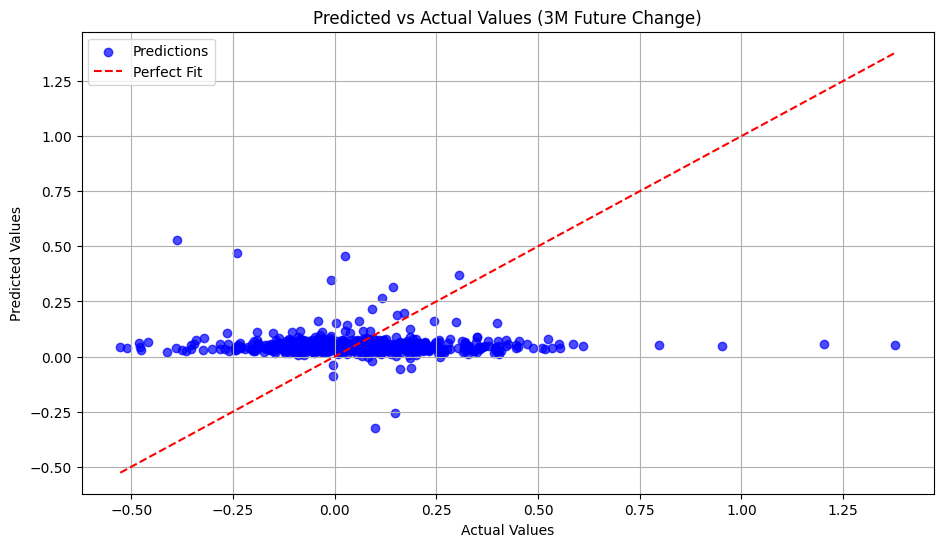

3M Future Change - R²: -0.0889
3M Future Change - MSE: 0.0443
3M Future Change - MAE: 0.1517


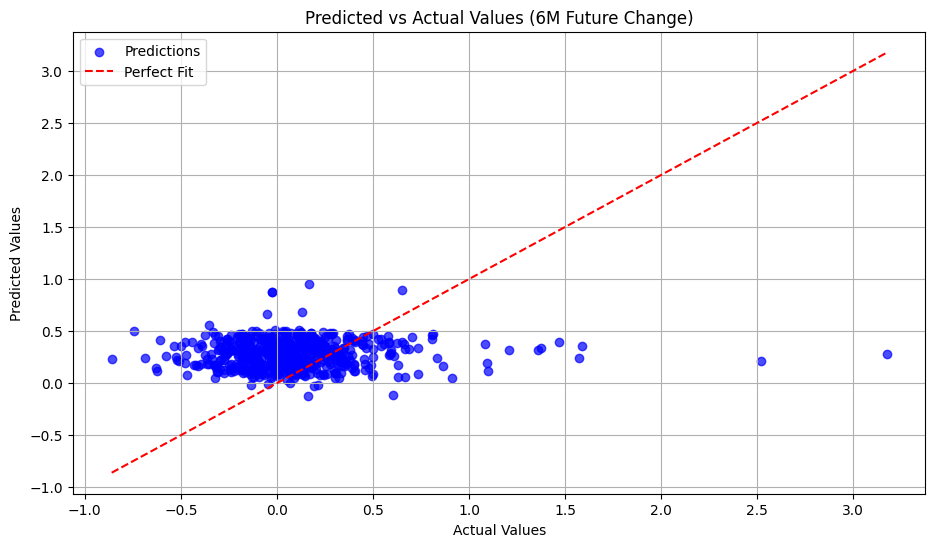

6M Future Change - R²: -0.4725
6M Future Change - MSE: 0.1770
6M Future Change - MAE: 0.3254


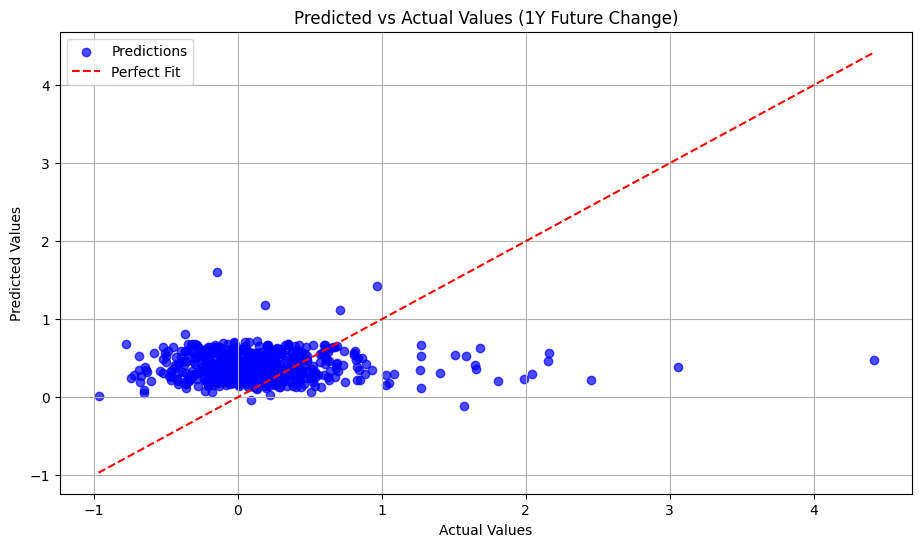

1Y Future Change - R²: -0.3939
1Y Future Change - MSE: 0.3214
1Y Future Change - MAE: 0.4322

Overall Scores:
Mean - R²: -0.3184
Mean - MSE: 0.1809
Mean - MAE: 0.3031


In [23]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [24]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [25]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0893079795170797


In [26]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*5, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,mean (%),3m (%),6m (%),1y (%)
0,AA,17.282441,19.936060,4.394326,27.516937
1,AAT,5.880127,-7.759504,8.239136,17.160750
2,ABM,7.328053,-9.512793,9.929937,21.567015
3,ABR,5.005326,-8.874480,6.322241,17.568216
4,ABT,4.912593,-4.421287,5.239655,13.919410
...,...,...,...,...,...
979,EQNR,7.802442,2.323224,10.336088,10.748015
980,BABA,2.789531,-9.315250,6.400422,11.283420
981,JD,3.075465,3.360969,-0.431078,6.296503
982,IQ,10.234500,7.562893,11.631753,11.508856


In [27]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [28]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://abb37e5cb44785b6a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
